<a href="https://www.kaggle.com/code/caasperart/license-plate-recognition-using-cnn?scriptVersionId=124991131" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## TR PDNN 2023
diadaptasi dari: https://github.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision

In [2]:
#  ! pip install imutils -q

import matplotlib.pyplot as plt
import numpy as np
import cv2
# import imutils
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from skimage import io
import urllib.request

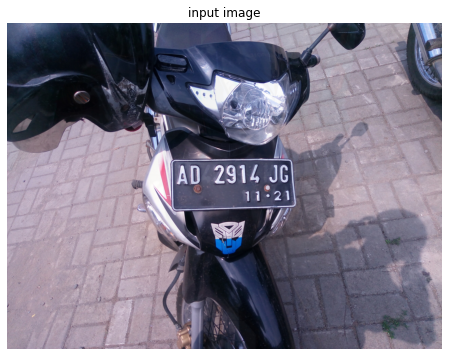

In [51]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()
    

# req = urllib.request.urlopen('https://awsimages.detik.net.id/customthumb/2011/05/09/648/plat-nomor-dalam.jpg')
# req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AB2638XU.jpg')
# req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AB5592EG.jpg')
req = urllib.request.urlopen('https://raw.githubusercontent.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision/main/test%20images/AD2914JG.jpg')


arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'    

# img = cv2.imread('../input/ai-indian-license-plate-recognition-data/car.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
display(img, 'input image')

# program untuk mendeteksi posisi plat nomor dari motor


detected plat no: 1
1092


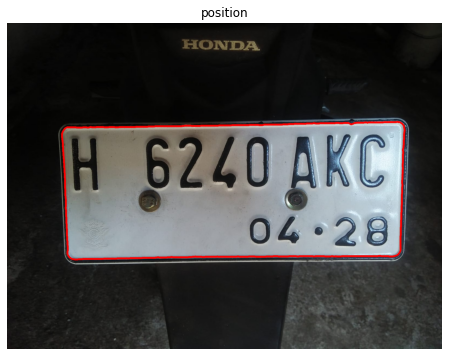

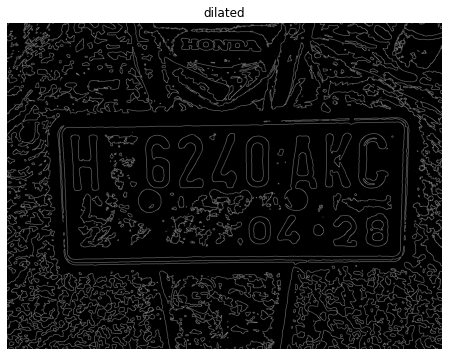

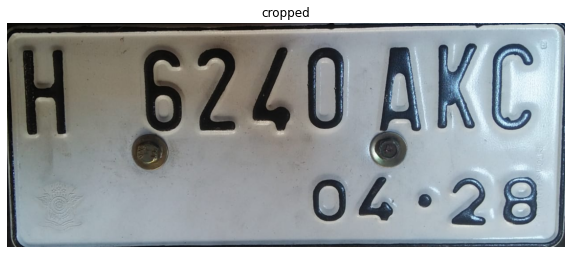

In [57]:
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H4517TI2.jpg')
img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
# req = urllib.request.urlopen('https://t-2.tstatic.net/gorontalo/foto/bank/images/12102022_plat-nomor-putih.jpg')

# req = urllib.request.urlopen('https://image.cermati.com/q_70,w_1200,h_800,c_fit/cgbt1mggrzxkk5p5xtot')
# arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
# img = cv2.imdecode(arr, -1) # 'Load it as it is'    

grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blured  = cv2.GaussianBlur(grayimg, (19,19), 0) 
hisimg  = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
edged   = cv2.Canny(hisimg, 10, 180)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1,1))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_copy = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 2)

platno=[]
index=0
sx = sy = sw = sh =[]

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h
#     print(f'aspect ratio from index: {index}, {aspect_ratio}, w: {w}, h: {h}')
    if w > 500 and h>200 and aspect_ratio <= 4 : 
        platno.append(index)
        sx.append(x)
        sy.append(y)
        sh.append(w)
        sw.append(h)
    index += 1
print(f'detected plat no: {len(platno)}')

if len(platno) == 1 or len(platno)>=1:
    indexplatno = platno[0]
    detectedimg = img.copy()
    x,y,w,h = cv2.boundingRect(contours[indexplatno])
    cv2.drawContours(detectedimg, contours, indexplatno, (0, 0, 255), 5)
    croppedimg = img[y: y+h, x:x+w]

print(indexplatno)

# display(hisimg, "contour")
# display(edged, "edged")
display(detectedimg, "position")
display(dilate, "dilated")
display(croppedimg, "cropped")



# program untuk mendeteksi digit dari plat nomor motor

x: 676, y: 51, w: 87, h: 190
x: 818, y: 50, w: 121, h: 277
x: 306, y: 48, w: 91, h: 196
x: 31, y: 47, w: 106, h: 207
x: 427, y: 45, w: 94, h: 199
x: 1089, y: 42, w: 112, h: 203
x: 967, y: 40, w: 99, h: 203
x: 551, y: 39, w: 92, h: 205
detected candidate plat no: 8
[76, 77]


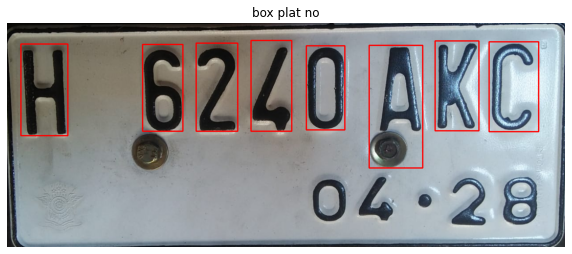

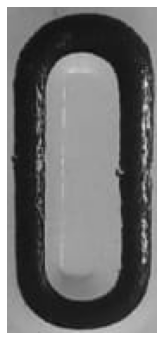

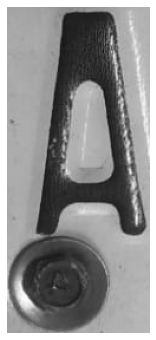

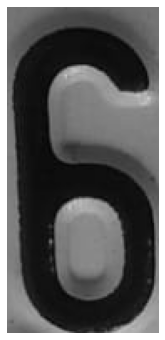

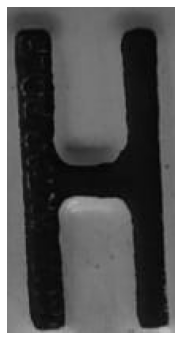

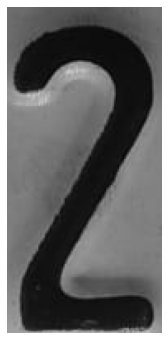

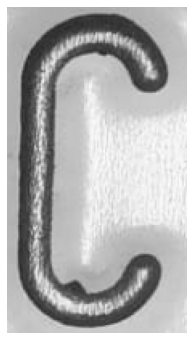

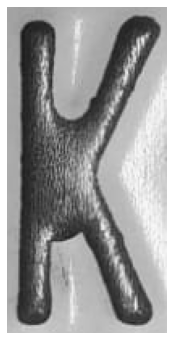

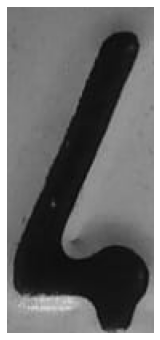

In [64]:
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC2.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6240AKC1.jpg')
# img = cv2.imread('/kaggle/input/haarcascadeplatenumber/H6498SI.jpg')

# req = urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/a/a5/Plat_Nomor_Nganjuk_%283_Huruf%29.jpg')
# arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
# img = cv2.imdecode(arr, -1)

# img = cv2.pyrDown(img)
grayimg = cv2.cvtColor(croppedimg, cv2.COLOR_BGR2GRAY)
blured  = cv2.GaussianBlur(grayimg, (21,21), 0) 
hisimg  = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
edged   = cv2.Canny(hisimg, 10, 120)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_NONE)
image_copy = croppedimg.copy()
imgrec = croppedimg.copy()

platno=[]
index=0
realPlatno=0
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h
    luas = w*h
#     print(f'aspect ratio from index: {index}, aspectRatio: {aspect_ratio}, w: {w}, h: {h}')
    if w > 42 and h>=70 and h <300 and aspect_ratio <= 0.7 and y<150: 
        platno.append(index)
        cv2.drawContours(image_copy, contours, index, (0, 255, 0), 2)
        print(f'x: {x}, y: {y}, w: {w}, h: {h}')
        cv2.rectangle(imgrec, (x,y), (x+w,y+h), (0,0,255),2)
        realPlatno+=1
    index += 1
print(f'detected candidate plat no: {len(platno)}')

for a in platno:
    xa,ya,wa,ha = cv2.boundingRect(contour[a])
#     print("=========================")
    for b in platno:
        if a == b:
            continue
        else:
            xb,yb,wb,hb = cv2.boundingRect(contour[b])
            ydif = ya-yb
            xdif = xa-xb
            wdif = wa-wb
            hdif = ha-hb
#             print(f'ydif: {ydif}, xdif: {xdif}, wdif: {wdif}, hdif: {hdif}')
            
counter=0
score=np.zeros(len(platno))
for a in platno:
    xa, ya, wa, ha = cv2.boundingRect(contours[a])
#     print("============================")
    for b in platno:
        if a == b :
            continue
        else:
            xb, yb, wb, hb = cv2.boundingRect(contours[b])
            ydif = ya-yb
#             print(f'ya: {ya}, yb: {yb}, ydif: {ydif}')
            
            if ydif<11:
                score[counter] = score[counter]+1
            
    counter += 1

indexRealChar=[]
charCounter=0
for sc in score:
    if sc != max(score):
        indexRealChar.append(platno[charCounter])
        
    charCounter+=1
    
print(indexRealChar)
finalimg = croppedimg.copy()
for char in indexRealChar:
    x,y,w,h = cv2.boundingRect(contours[char])
    cv2.rectangle(finalimg, (x,y), (x+w,y+h), (150,0,0),2)
    
display(imgrec, "box plat no")
# display(finalimg, "final hopefully")
# display(hisimg, "detected plat no")
# display(blured, "detected plat no")
# display(image_copy, "contour")
# display(edged, "edged")
# display(dilate, "dilated")

for char in platno:
    x,y,w,h = cv2.boundingRect(contours[char])
    crop = grayimg[y: y+h, x:x+w]
    display(crop)

# **Selanjutnya buat program untuk ekstract setiap digit dari plat nomor dan melakukan klasifikasi karakter yang didapatkan**

In [ ]:
contours1, hierarchy1 = cv2.findContours(image=grayimg, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
image_contour_blue = img.copy()
cv2.drawContours(image=image_contour_blue, contours=contours1, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
display(image_contour_blue)

In [ ]:
display(output_img, 'detected license plate in the input image')

In [ ]:
display(plate, 'extracted license plate from the image')

In [ ]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [ ]:
# Let's see the segmented characters
char = segment_characters(plate)

In [ ]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

### Model for characters

In [ ]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '../input/ai-indian-license-plate-recognition-data/data/data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

In [ ]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

In [ ]:
model.summary()

In [ ]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.99):
      self.model.stop_training = True

In [ ]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 80, verbose=1, callbacks=callbacks)

In [ ]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

In [ ]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

In [ ]:
plate_number = show_results()
output_img, plate = detect_plate(img, plate_number)
display(output_img, 'detected license plate number in the input image')